In [1]:
import pandas as pd
import hvplot.pandas
import holoviews as hv
import numpy as np
from holoviews import opts
import panel as pn
pn.extension()
hv.extension('bokeh')
import geopandas as gpd
from shapely.geometry import Point
import folium
import branca.colormap as cm
import os
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Define the folder path and file name
data_csv_file="data/commute/CSVLog_20240823_060546.CSV"

output_folder_path = 'output/date/analysis_20240823_am/'  # Change this to your folder path

df_file_name = "df.csv"
df_file_path = os.path.join(output_folder_path, df_file_name)
map_moving_file_path = os.path.join(output_folder_path, 'map_moving.html')
#create folder folder if it does not exist
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

In [3]:
df=pd.read_csv(data_csv_file)
df.columns = df.columns.str.strip()
df_file_path = os.path.join(output_folder_path, df_file_name)
df.to_csv(df_file_path, index=False)
#df.head()

In [4]:
column_list=df.columns.tolist()
print(column_list)

['Time (sec)', 'Instant fuel economy (MPG)', 'Calculated load value (%)', 'Engine coolant temperature (°F)', 'Intake manifold absolute pressure (inHg)', 'Engine RPM (RPM)', 'Vehicle speed (MPH)', 'Relative throttle position (%)', 'Ambient air temperature (°F)', 'Relative accelerator pedal position (%)', 'Engine oil temperature (°F)', 'Intake air temperature bank 1  sensor 1 (°F)', 'Mass air flow rate (lb/min)', 'Boost (psi)', 'Engine Power (hp)', 'Engine Torque (lb•ft)', 'Trip Distance (miles)', 'Trip Fuel Economy (MPG)', 'Latitude (deg)', 'Longitude (deg)']


In [5]:
df=df[['Time (sec)', 'Vehicle speed (MPH)', 'Relative accelerator pedal position (%)','Engine RPM (RPM)', 'Boost (psi)', 'Engine Power (hp)','Mass air flow rate (lb/min)','Intake manifold absolute pressure (inHg)', 'Ambient air temperature (°F)','Trip Distance (miles)','Instant fuel economy (MPG)', 'Trip Fuel Economy (MPG)', 'Latitude (deg)', 'Longitude (deg)','Relative throttle position (%)']]
df.head()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),Latitude (deg),Longitude (deg),Relative throttle position (%)
0,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0,0.0,0.0,0.0,45.058060,-92.954704,0.000000
1,0.998,0.0,0.0,0.0,0.000000,9.245465,0.0,0.000000,0,0.0,0.0,0.0,45.058070,-92.954700,0.000000
2,2.014,0.0,0.0,0.0,0.000000,9.245465,0.0,0.000000,0,0.0,0.0,0.0,45.058064,-92.954690,0.000000
3,2.965,0.0,0.0,0.0,0.000000,9.245465,0.0,0.000000,0,0.0,0.0,0.0,45.058064,-92.954690,0.000000
4,4.020,0.0,0.0,1610.5,-10.732793,9.004384,0.0,7.677826,68,0.0,0.0,0.0,45.058044,-92.954670,5.882353


In [6]:
# To avoid math errors in situations where values = 0
df['Boost (psi)'] = df['Boost (psi)'].bfill().infer_objects()
df.loc[df['Boost (psi)'] == 0, 'Boost (psi)'] = 0.01

df.head()


,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),Latitude (deg),Longitude (deg),Relative throttle position (%)
0,0.000,0.0,0.0,0.0,0.010000,0.000000,0.0,0.000000,0,0.0,0.0,0.0,45.058060,-92.954704,0.000000
1,0.998,0.0,0.0,0.0,0.010000,9.245465,0.0,0.000000,0,0.0,0.0,0.0,45.058070,-92.954700,0.000000
2,2.014,0.0,0.0,0.0,0.010000,9.245465,0.0,0.000000,0,0.0,0.0,0.0,45.058064,-92.954690,0.000000
3,2.965,0.0,0.0,0.0,0.010000,9.245465,0.0,0.000000,0,0.0,0.0,0.0,45.058064,-92.954690,0.000000
4,4.020,0.0,0.0,1610.5,-10.732793,9.004384,0.0,7.677826,68,0.0,0.0,0.0,45.058044,-92.954670,5.882353


In [7]:
def clean_data(df):
    # Round columns 'Time (sec)', ' Engine RPM (RPM)' and 2 other columns (Number of decimals: 0)
    df = df.round({'Time (sec)': 0, 'Engine RPM (RPM)': 0, 'Engine Power (hp)': 0, 'Time (sec)': 0})
    # Round columns ' Instant fuel economy (MPG)', ' Vehicle speed (MPH)' and 4 other columns (Number of decimals: 1)
    df = df.round({'Instant fuel economy (MPG)': 1, 'Vehicle speed (MPH)': 1,'Relative throttle position (%)': 1, 'Relative accelerator pedal position (%)': 1, 'Trip Distance (miles)': 1, 'Trip Fuel Economy (MPG)': 1,'Boost (psi)':1})
    # Round columns ' Intake manifold absolute pressure (inHg)', ' Mass air flow rate (lb/min)', ' Bearing (deg)' (Number of decimals: 2)
    df = df.round({'Intake manifold absolute pressure (inHg)': 2, 'Mass air flow rate (lb/min)': 2,'Bearing (deg)': 2})
    # Drop columns: ' Intake manifold absolute pressure (inHg)', ' Mass air flow rate (lb/min)' and 3 other columns
    df = df.drop(columns=['Relative throttle position (%)'])
    # Rename column 'Latitude (deg)' to 'latitude'
    df = df.rename(columns={'Latitude (deg)': 'latitude'})
    # Rename column 'Longitude (deg)' to 'longitude'
    df = df.rename(columns={'Longitude (deg)': 'longitude'})
    return df

df_clean = clean_data(df.copy())
df_clean.head()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0.0,45.058060,-92.954704
1,1.0,0.0,0.0,0.0,0.0,9.0,0.0,0.00,0,0.0,0.0,0.0,45.058070,-92.954700
2,2.0,0.0,0.0,0.0,0.0,9.0,0.0,0.00,0,0.0,0.0,0.0,45.058064,-92.954690
3,3.0,0.0,0.0,0.0,0.0,9.0,0.0,0.00,0,0.0,0.0,0.0,45.058064,-92.954690
4,4.0,0.0,0.0,1610.0,-10.7,9.0,0.0,7.68,68,0.0,0.0,0.0,45.058044,-92.954670


In [8]:
#create dataframe where vehicle is stationary
df_stationary = df_clean[df_clean['Vehicle speed (MPH)'] == 0]
df_stationary.head()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0.0,0.0,45.058060,-92.954704
1,1.0,0.0,0.0,0.0,0.0,9.0,0.0,0.00,0,0.0,0.0,0.0,45.058070,-92.954700
2,2.0,0.0,0.0,0.0,0.0,9.0,0.0,0.00,0,0.0,0.0,0.0,45.058064,-92.954690
3,3.0,0.0,0.0,0.0,0.0,9.0,0.0,0.00,0,0.0,0.0,0.0,45.058064,-92.954690
4,4.0,0.0,0.0,1610.0,-10.7,9.0,0.0,7.68,68,0.0,0.0,0.0,45.058044,-92.954670


In [9]:
#creates dataframe where the vehicle is moving or is about to begin motion after being stationary
df_clean['next_mph'] = df_clean['Vehicle speed (MPH)'].shift(-1)
mask = (df_clean['Vehicle speed (MPH)'] > 0) | ((df_clean['Vehicle speed (MPH)'] == 0) & (df_clean['next_mph'] > 0))
df_moving= df_clean[mask].drop(columns=['next_mph'])
df_moving.head()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude
16,25.0,0.0,0.0,1019.0,-8.0,9.0,0.78,13.29,68,0.0,0.0,0.0,45.058105,-92.954690
17,26.0,0.6,0.0,1006.0,-7.8,9.0,0.80,13.58,68,0.0,0.9,0.1,45.058100,-92.954704
18,27.0,0.6,0.0,1006.0,-7.8,9.0,0.80,13.58,68,0.0,0.9,0.1,45.058098,-92.954720
19,28.0,0.6,0.0,1006.0,-7.8,9.0,0.80,13.58,68,0.0,0.9,0.1,45.058098,-92.954730
20,29.0,2.5,0.0,861.0,-8.0,7.0,0.77,13.29,68,0.0,5.1,0.5,45.058094,-92.954735


In [10]:
#experimenting 
df_moving['Mass Air/Boost']=df_moving['Mass air flow rate (lb/min)']/df_moving['Boost (psi)']
df_moving['Mass Air/manPress']=df_moving['Mass air flow rate (lb/min)']/df_moving['Intake manifold absolute pressure (inHg)']
df_moving.head()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude,Mass Air/Boost,Mass Air/manPress
16,25.0,0.0,0.0,1019.0,-8.0,9.0,0.78,13.29,68,0.0,0.0,0.0,45.058105,-92.954690,-0.097500,0.058691
17,26.0,0.6,0.0,1006.0,-7.8,9.0,0.80,13.58,68,0.0,0.9,0.1,45.058100,-92.954704,-0.102564,0.058910
18,27.0,0.6,0.0,1006.0,-7.8,9.0,0.80,13.58,68,0.0,0.9,0.1,45.058098,-92.954720,-0.102564,0.058910
19,28.0,0.6,0.0,1006.0,-7.8,9.0,0.80,13.58,68,0.0,0.9,0.1,45.058098,-92.954730,-0.102564,0.058910
20,29.0,2.5,0.0,861.0,-8.0,7.0,0.77,13.29,68,0.0,5.1,0.5,45.058094,-92.954735,-0.096250,0.057938


In [11]:
#creates dataframe where vehicle is moving and speed is less than 10mph
mask = (df_moving['Vehicle speed (MPH)'] <= 10)
df_less_10 = df_moving[mask]
#df_less_10.head()
df_less_10.describe()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude,Mass Air/Boost,Mass Air/manPress
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.0,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,1468.554348,3.885870,2.397826,1023.228261,-8.039130,7.239130,0.742065,13.155978,68.0,22.305435,9.863043,20.552174,44.930943,-93.207661,-0.373511,0.053034
std,1031.728863,3.342881,4.618619,468.172695,3.044287,8.474097,0.533062,6.196191,0.0,16.360999,9.410979,10.152448,0.093670,0.183214,0.867710,0.012354
min,25.000000,0.000000,0.000000,593.000000,-11.300000,3.000000,0.330000,6.500000,68.0,0.000000,0.000000,0.000000,44.860520,-93.351890,-4.900000,0.036410
25%,105.750000,1.200000,0.000000,737.000000,-9.900000,4.000000,0.467500,9.450000,68.0,0.400000,4.500000,11.300000,44.860557,-93.341910,-0.102564,0.044563
50%,2238.500000,1.900000,0.000000,777.000000,-9.000000,4.000000,0.500000,11.220000,68.0,34.600000,4.500000,27.400000,44.860687,-93.341896,-0.055556,0.049149
75%,2268.250000,6.200000,2.800000,1013.750000,-7.950000,6.000000,0.785000,13.362500,68.0,34.600000,14.800000,27.400000,45.056085,-92.961388,-0.045631,0.058020
max,2291.000000,9.900000,15.300000,2479.000000,-0.600000,49.000000,2.940000,28.350000,68.0,34.600000,39.500000,27.500000,45.058105,-92.954690,-0.030275,0.103704


In [12]:
#creates dataframe where vehicle is moving and speed is between 10 and 20mph
mask = (df_moving['Vehicle speed (MPH)'] >= 10) & (df_moving['Vehicle speed (MPH)'] <= 20)
df_10_20 = df_moving[mask]
#df_10_20.head()
df_10_20.describe()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude,Mass Air/Boost,Mass Air/manPress
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.0,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,1404.010989,14.984615,5.242857,1555.417582,-6.082418,20.538462,1.563956,17.150989,68.0,21.479121,25.673626,21.191209,44.935157,-93.200511,-0.369481,0.081547
std,1008.536249,2.363938,5.237178,626.012337,5.915527,20.866937,1.395879,12.030943,0.0,16.431416,20.216835,8.670251,0.094252,0.184441,2.384500,0.021600
min,39.000000,10.600000,0.000000,813.000000,-12.000000,3.000000,0.330000,5.020000,68.0,0.000000,2.400000,2.000000,44.860150,-93.351890,-9.250000,0.046544
25%,209.500000,13.700000,0.000000,1167.000000,-11.000000,5.000000,0.465000,7.090000,68.0,1.650000,6.600000,16.700000,44.860332,-93.344977,-0.128188,0.068417
50%,2168.000000,14.900000,4.300000,1246.000000,-9.100000,10.000000,0.810000,10.930000,68.0,34.200000,21.700000,27.400000,44.863070,-93.343020,-0.060194,0.073358
75%,2213.500000,16.200000,9.200000,1733.000000,-0.750000,33.500000,2.235000,28.055000,68.0,34.500000,41.900000,27.400000,45.050283,-92.984282,-0.030931,0.087688
max,2236.000000,19.900000,16.100000,3118.000000,7.400000,69.000000,4.460000,44.590000,68.0,34.600000,77.200000,27.500000,45.057915,-92.954860,6.328571,0.142857


In [13]:
#creates dataframe where vehicle is moving and speed is between 20 and 30mph
mask = (df_moving['Vehicle speed (MPH)'] >= 20) & (df_moving['Vehicle speed (MPH)'] <= 30)
df_20_30 = df_moving[mask]
#df_20_30.head()
df_20_30.describe()


,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude,Mass Air/Boost,Mass Air/manPress
count,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1112.290000,25.25500,3.047000,1526.970000,-6.708000,19.920000,1.632900,15.863900,68.0,17.041000,41.91400,18.397000,44.960268,-93.151342,0.300730,0.093318
std,1026.559816,2.78888,5.283125,362.174478,5.955724,20.495222,1.512595,12.107863,0.0,16.874361,33.83031,9.388737,0.095905,0.193633,1.337207,0.025757
min,44.000000,20.50000,0.000000,1189.000000,-12.000000,3.000000,0.360000,5.020000,68.0,0.000000,3.70000,3.700000,44.860382,-93.351890,-2.370000,0.068783
25%,76.750000,23.60000,0.000000,1260.000000,-11.300000,5.750000,0.505000,6.500000,68.0,0.200000,12.30000,9.200000,44.863388,-93.346227,-0.094681,0.073308
50%,322.500000,25.50000,0.000000,1437.000000,-9.900000,10.000000,0.810000,9.450000,68.0,2.700000,32.95000,18.500000,45.035049,-92.985525,-0.048673,0.085672
75%,2161.250000,28.00000,4.800000,1607.500000,-2.050000,29.000000,2.570000,25.395000,68.0,34.200000,59.80000,27.400000,45.056994,-92.958345,-0.031028,0.103240
max,2192.000000,29.80000,22.400000,2586.000000,10.300000,94.000000,6.940000,50.500000,68.0,34.400000,113.80000,27.500000,45.057453,-92.954870,8.433333,0.162452


In [14]:
#creates dataframe where vehicle is moving and speed is between 30 and 40mph
mask = (df_moving['Vehicle speed (MPH)'] >= 30) & (df_moving['Vehicle speed (MPH)'] <= 40)
df_30_40 = df_moving[mask]
#df_30_40.head()
df_30_40.describe()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude,Mass Air/Boost,Mass Air/manPress
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.0,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,1207.061224,34.806122,1.973469,1390.857143,-8.659184,15.530612,1.107143,11.885306,68.0,18.316327,88.402041,22.369388,44.953006,-93.170186,0.037555,0.080229
std,955.582336,3.343489,4.656840,276.242873,5.977490,24.794238,1.493150,12.177381,0.0,16.214093,47.415638,5.226264,0.091807,0.184268,0.300819,0.014627
min,196.000000,30.400000,0.000000,1239.000000,-12.000000,3.000000,0.370000,5.020000,68.0,1.500000,4.600000,15.300000,44.861120,-93.351450,-0.425000,0.073084
25%,237.000000,32.300000,0.000000,1280.000000,-11.900000,4.000000,0.400000,5.320000,68.0,1.700000,69.400000,17.100000,44.864100,-93.348900,-0.058654,0.073705
50%,2071.000000,33.600000,0.000000,1290.000000,-11.300000,5.000000,0.490000,6.500000,68.0,33.800000,94.300000,27.300000,44.865765,-93.345730,-0.040000,0.074970
75%,2144.000000,37.900000,0.000000,1302.000000,-9.700000,7.000000,0.740000,9.740000,68.0,34.100000,124.200000,27.400000,45.049084,-92.984850,-0.031667,0.075975
max,2185.000000,39.800000,17.600000,2646.000000,9.000000,102.000000,7.130000,47.840000,68.0,34.400000,156.000000,27.500000,45.050316,-92.982030,1.034286,0.149038


In [15]:
#creates dataframe where vehicle is moving and speed is between 40 and 50mph
mask = (df_moving['Vehicle speed (MPH)'] >= 40) & (df_moving['Vehicle speed (MPH)'] <= 50)
df_40_50 = df_moving[mask]
#df_40_50.head()
df_40_50.describe()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude,Mass Air/Boost,Mass Air/manPress
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.0,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,313.742515,44.826347,6.102395,1740.628743,-4.124551,26.640719,2.255689,21.148383,68.0,3.324551,43.039521,16.135329,45.037167,-92.998218,inf,0.101558
std,424.601301,2.577923,5.460559,393.804772,4.582306,19.920390,1.354807,9.331531,0.0,7.308326,39.908439,3.025715,0.041218,0.084670,NaN,0.024044
min,113.000000,40.400000,0.000000,1286.000000,-12.000000,4.000000,0.400000,5.020000,68.0,0.400000,5.000000,11.400000,44.865906,-93.350670,-9.700000,0.074762
25%,154.500000,42.900000,0.000000,1432.000000,-6.700000,14.000000,1.250000,15.950000,68.0,1.000000,18.400000,14.700000,45.041003,-92.984860,-0.672414,0.082759
50%,240.000000,44.700000,6.700000,1613.000000,-4.100000,22.000000,2.140000,21.260000,68.0,1.800000,27.600000,15.500000,45.048580,-92.984740,-0.240351,0.095047
75%,283.500000,46.600000,10.200000,1972.000000,-1.200000,35.000000,2.895000,27.170000,68.0,2.300000,45.550000,16.800000,45.050556,-92.971760,-0.041375,0.116876
max,2070.000000,49.700000,31.800000,3274.000000,11.600000,117.000000,8.480000,53.150000,68.0,33.800000,168.100000,27.500000,45.055250,-92.962810,inf,0.189037


In [16]:
mask = (df_moving['Vehicle speed (MPH)'] >= 50) & (df_moving['Vehicle speed (MPH)'] <= 60)
df_50_60 = df_moving[mask]
df_50_60.describe()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude,Mass Air/Boost,Mass Air/manPress
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.0,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,1266.397059,57.917647,8.414706,2039.294118,-4.751471,30.367647,2.404853,19.854706,68.0,19.547059,67.073529,25.322059,45.012139,-93.255918,inf,0.115063
std,552.060162,1.985916,9.201740,555.621047,6.527313,31.580697,1.835865,13.289218,0.0,9.842134,55.453583,3.710165,0.079965,0.126861,NaN,0.024999
min,332.000000,50.300000,0.000000,1521.000000,-12.000000,5.000000,0.470000,5.020000,68.0,2.900000,4.100000,17.200000,44.867520,-93.350670,-37.600000,0.089127
25%,1173.250000,57.200000,0.000000,1776.750000,-11.500000,7.000000,0.690000,6.200000,68.0,17.925000,17.125000,26.800000,44.968260,-93.346033,-0.216928,0.103215
50%,1194.500000,58.400000,7.800000,1861.000000,-5.100000,19.000000,2.100000,19.190000,68.0,18.300000,43.250000,26.900000,45.052178,-93.291542,-0.052586,0.106348
75%,1667.000000,59.700000,13.200000,2074.250000,0.400000,46.000000,3.545000,30.342500,68.0,26.725000,122.650000,27.100000,45.069789,-93.284390,0.841204,0.117184
max,2061.000000,59.700000,47.800000,4458.000000,10.300000,193.000000,7.580000,50.500000,68.0,33.700000,159.500000,27.400000,45.070045,-92.988106,inf,0.221219


In [17]:
#creates dataframe where vehicle is moving and speed is between 40 and 50mph
mask = (df_moving['Vehicle speed (MPH)'] >= 60) & (df_moving['Vehicle speed (MPH)'] <= 70)
df_60_70 = df_moving[mask]
#df_60_70.head()
df_60_70.describe()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude,Mass Air/Boost,Mass Air/manPress
count,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.0,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000
mean,1193.200363,64.334685,6.932506,2016.133777,-2.992857,30.650726,2.743414,23.437893,68.0,18.298729,43.106053,25.286683,45.014548,-93.240422,inf,0.116391
std,497.860850,2.076925,5.364292,155.007464,4.691862,18.186687,1.204068,9.550887,0.0,8.847187,31.840330,2.400924,0.058152,0.117325,NaN,0.009344
min,344.000000,60.300000,0.000000,1804.000000,-11.700000,6.000000,0.590000,5.610000,68.0,3.100000,4.100000,16.800000,44.869972,-93.350900,-35.700000,0.104578
25%,758.750000,62.800000,0.000000,1952.000000,-6.200000,18.000000,1.950000,16.830000,68.0,10.600000,20.975000,24.100000,44.977098,-93.348735,-0.851136,0.112583
50%,1182.500000,64.000000,7.800000,2007.000000,-2.600000,27.000000,2.800000,24.210000,68.0,18.100000,32.500000,26.700000,45.037514,-93.287520,-0.261597,0.115734
75%,1629.250000,65.900000,11.000000,2060.000000,0.400000,42.000000,3.520000,30.420000,68.0,26.025000,49.625000,26.900000,45.061199,-93.137877,0.957044,0.118921
max,2050.000000,69.600000,24.300000,4847.000000,11.000000,208.000000,13.630000,51.970000,68.0,33.500000,145.500000,27.300000,45.070015,-92.992060,inf,0.279848


In [18]:
mask = (df_moving['Vehicle speed (MPH)'] >= 70)
df_grt_70 = df_moving[mask]
#df_grt_70.head()
df_grt_70.describe()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude,Mass Air/Boost,Mass Air/manPress
count,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.00000,10.000000,10.0,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1266.300000,70.900000,6.28000,2205.500000,-3.420000,37.600000,2.91400,22.530000,68.0,19.57000,48.43000,25.680000,45.024663,-93.290020,-1.031897,0.128550
std,398.874542,0.571548,4.94611,65.476459,7.182819,32.874171,1.92332,14.602245,0.0,7.09946,38.70636,2.361167,0.006996,0.123776,2.871783,0.002307
min,509.000000,70.200000,0.00000,2112.000000,-11.500000,7.000000,0.78000,6.200000,68.0,6.10000,8.90000,21.200000,45.020380,-93.349045,-9.050000,0.125618
25%,1452.250000,70.350000,1.27500,2166.250000,-8.700000,15.750000,1.51750,11.740000,68.0,22.90000,21.97500,26.800000,45.021001,-93.348845,-0.736364,0.126539
50%,1454.500000,70.800000,6.70000,2196.000000,-4.500000,26.000000,2.64000,20.375000,68.0,22.90000,37.75000,26.800000,45.021638,-93.348643,-0.197238,0.128381
75%,1456.750000,71.500000,10.00000,2250.500000,-1.100000,44.750000,3.45750,27.237500,68.0,22.97500,62.30000,26.800000,45.022272,-93.348450,-0.076110,0.130831
max,1459.000000,71.500000,12.50000,2327.000000,10.200000,109.000000,6.59000,50.200000,68.0,23.00000,132.00000,26.800000,45.037890,-93.054970,0.841791,0.131275


In [19]:
#creates dataframe where vehicle is moving and speed is between 40 and 50mph
mask = (df_moving['Vehicle speed (MPH)'] >= 55) & (df_moving['Vehicle speed (MPH)'] <= 75)
df_55_75 = df_moving[mask]
#df_55_75.head()
df_55_75.describe()

,Time (sec),Vehicle speed (MPH),Relative accelerator pedal position (%),Engine RPM (RPM),Boost (psi),Engine Power (hp),Mass air flow rate (lb/min),Intake manifold absolute pressure (inHg),Ambient air temperature (°F),Trip Distance (miles),Instant fuel economy (MPG),Trip Fuel Economy (MPG),latitude,longitude,Mass Air/Boost,Mass Air/manPress
count,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.0,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000
mean,1194.500000,64.158991,7.001508,2018.933875,-3.039211,30.738399,2.736624,23.343225,68.0,18.319838,43.787529,25.288805,45.014925,-93.241149,inf,0.116441
std,497.820249,2.383181,5.557046,185.391181,4.786598,18.955044,1.236099,9.743597,0.0,8.847799,32.968724,2.457607,0.058543,0.117673,NaN,0.010245
min,333.000000,55.300000,0.000000,1670.000000,-11.900000,5.000000,0.520000,5.320000,68.0,2.900000,4.100000,16.800000,44.868576,-93.350900,-37.600000,0.097744
25%,763.750000,62.800000,0.000000,1950.000000,-6.400000,18.000000,1.917500,16.540000,68.0,10.700000,20.800000,24.100000,44.977819,-93.348604,-0.822727,0.112455
50%,1194.500000,64.000000,7.800000,2007.000000,-2.600000,27.000000,2.790000,24.210000,68.0,18.300000,32.550000,26.700000,45.037514,-93.291542,-0.246479,0.115684
75%,1625.250000,65.900000,11.400000,2062.000000,0.400000,42.000000,3.520000,30.420000,68.0,26.000000,50.200000,26.900000,45.062159,-93.139737,0.938909,0.119061
max,2056.000000,71.500000,47.800000,4847.000000,11.000000,208.000000,13.630000,51.970000,68.0,33.600000,155.300000,27.300000,45.070045,-92.988430,inf,0.279848


40-50mph
Average Boost: -4.12
Value Counts: 167
Values > 100mpg: 20
Values <= 100mpg: 147
Percent above 100mpg: 11.98%
Mean MPG: 43.04
mpg Quartiles
   Percentile  40-50mph (mpg)
0        0.25           18.40
1        0.50           27.60
2        0.75           45.55
Boost Quartiles
   Percentile  Value (psi)
0        0.25         -6.7
1        0.50         -4.1
2        0.75         -1.2


<Axes: ylabel='Value (psi)'>

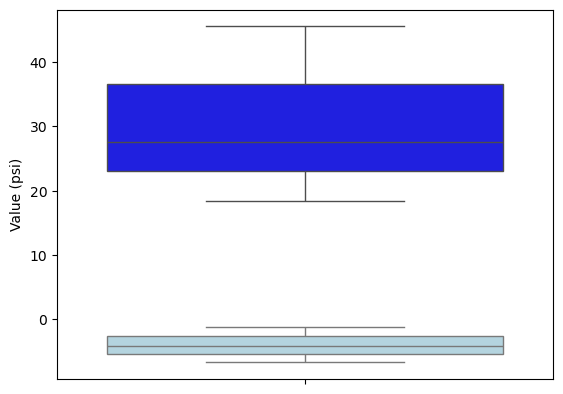

In [20]:
mask_grt_100 = df_40_50['Instant fuel economy (MPG)'] > 100
mpg_grt_100_40_50 = mask_grt_100.sum()
mask_lte_100 = df_40_50['Instant fuel economy (MPG)']  <= 100
mpg_lte_100_40_50 = mask_lte_100.sum()

mph_40_50_boost_mean =df_40_50['Boost (psi)'].mean().round(2) 
mph_40_50_boost_quantiles=df_40_50['Boost (psi)'].quantile([0.25,0.50,0.75])
df_40_50_boost_quantiles = pd.DataFrame(mph_40_50_boost_quantiles)
df_40_50_boost_quantiles = df_40_50_boost_quantiles.reset_index()
df_40_50_boost_quantiles.columns = ['Percentile', 'Value (psi)']

mpg_40_50_count=len(df_40_50)
mpg_40_50_mpg_mean=df_40_50['Instant fuel economy (MPG)'].mean().round(2)
mpg_40_50_100_quantiles=df_40_50['Instant fuel economy (MPG)'].quantile([0.25,0.50,0.75])
mpg_40_50_100_per=((mpg_grt_100_40_50/mpg_40_50_count)*100).round(2)
df_40_50_100_quantiles = pd.DataFrame(mpg_40_50_100_quantiles)
df_40_50_100_quantiles = df_40_50_100_quantiles.reset_index()
df_40_50_100_quantiles.columns = ['Percentile', '40-50mph (mpg)']

print("40-50mph")
print(f"Average Boost: {mph_40_50_boost_mean}")
print(f"Value Counts: {mpg_40_50_count}")
print(f"Values > 100mpg: {mpg_grt_100_40_50}")
print(f"Values <= 100mpg: {mpg_lte_100_40_50}")
print(f"Percent above 100mpg: {mpg_40_50_100_per}%")
print(f"Mean MPG: {mpg_40_50_mpg_mean}")
print("mpg Quartiles")
print(df_40_50_100_quantiles)
print("Boost Quartiles")
print(df_40_50_boost_quantiles)
sns.boxplot(y=df_40_50_boost_quantiles['Value (psi)'], color='lightblue')
sns.boxplot(y=df_40_50_100_quantiles['40-50mph (mpg)'], color='blue')

50-60mph
Average Boost: -4.75
Value Counts: 68
Values > 100mpg: 24
Values <= 100mpg: 44
Percent above 100mpg: 35.29%
Mean MPG: 67.07
mpg Quartiles
   Percentile  50-60mph (mpg)
0        0.25          17.125
1        0.50          43.250
2        0.75         122.650
Boost Quartiles
   Percentile  Value (psi)
0        0.25        -11.5
1        0.50         -5.1
2        0.75          0.4


<Axes: ylabel='Value (psi)'>

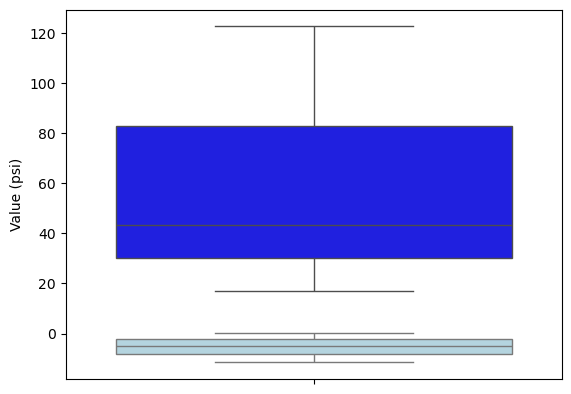

In [21]:
mask_grt_100 = df_50_60['Instant fuel economy (MPG)'] > 100
mpg_grt_100_50_60 = mask_grt_100.sum()
mask_lte_100 = df_50_60['Instant fuel economy (MPG)']  <= 100
mpg_lte_100_50_60 = mask_lte_100.sum()

mph_50_60_boost_mean =df_50_60['Boost (psi)'].mean().round(2) 
mph_50_60_boost_quantiles=df_50_60['Boost (psi)'].quantile([0.25,0.50,0.75])
df_50_60_boost_quantiles = pd.DataFrame(mph_50_60_boost_quantiles)
df_50_60_boost_quantiles = df_50_60_boost_quantiles.reset_index()
df_50_60_boost_quantiles.columns = ['Percentile', 'Value (psi)']

mpg_50_60_count=len(df_50_60)
mpg_50_60_mpg_mean=df_50_60['Instant fuel economy (MPG)'].mean().round(2)
mpg_50_60_100_quantiles=df_50_60['Instant fuel economy (MPG)'].quantile([0.25,0.50,0.75])
mpg_50_60_100_per=((mpg_grt_100_50_60/mpg_50_60_count)*100).round(2)
df_50_60_100_quantiles = pd.DataFrame(mpg_50_60_100_quantiles)
df_50_60_100_quantiles = df_50_60_100_quantiles.reset_index()
df_50_60_100_quantiles.columns = ['Percentile', '50-60mph (mpg)']

print("50-60mph")
print(f"Average Boost: {mph_50_60_boost_mean}")
print(f"Value Counts: {mpg_50_60_count}")
print(f"Values > 100mpg: {mpg_grt_100_50_60}")
print(f"Values <= 100mpg: {mpg_lte_100_50_60}")
print(f"Percent above 100mpg: {mpg_50_60_100_per}%")
print(f"Mean MPG: {mpg_50_60_mpg_mean}")
print("mpg Quartiles")
print(df_50_60_100_quantiles)
print("Boost Quartiles")
print(df_50_60_boost_quantiles)
sns.boxplot(y=df_50_60_boost_quantiles['Value (psi)'], color='lightblue')
sns.boxplot(y=df_50_60_100_quantiles['50-60mph (mpg)'], color='blue')

60-70mph
Average Boost: -2.99
Value Counts: 1652
Values > 100mpg: 146
Values <= 100mpg: 1506
Percent above 100mpg: 8.84%
Mean MPG: 43.11
mpg Quartiles
   Percentile  60-70mph (mpg)
0        0.25          20.975
1        0.50          32.500
2        0.75          49.625
Boost Quartiles
   Percentile  Value (psi)
0        0.25         -6.2
1        0.50         -2.6
2        0.75          0.4


<Axes: ylabel='Value (psi)'>

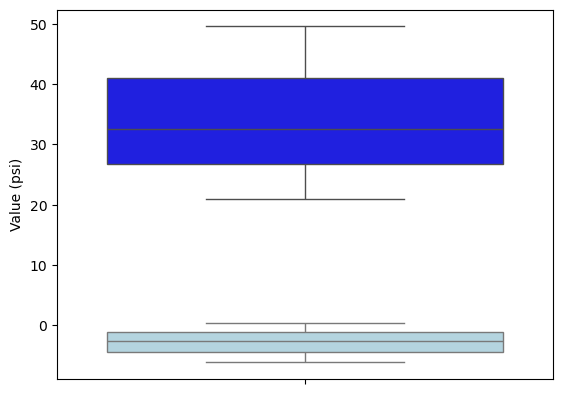

In [22]:
mask_grt_100 = df_60_70['Instant fuel economy (MPG)'] > 100
mpg_grt_100_60_70 = mask_grt_100.sum()
mask_lte_100 = df_60_70['Instant fuel economy (MPG)']  <= 100
mpg_lte_100_60_70 = mask_lte_100.sum()

mph_60_70_boost_mean =df_60_70['Boost (psi)'].mean().round(2) 
mph_60_70_boost_quantiles=df_60_70['Boost (psi)'].quantile([0.25,0.50,0.75])
df_60_70_boost_quantiles = pd.DataFrame(mph_60_70_boost_quantiles)
df_60_70_boost_quantiles = df_60_70_boost_quantiles.reset_index()
df_60_70_boost_quantiles.columns = ['Percentile', 'Value (psi)']

mpg_60_70_count=len(df_60_70)
mpg_60_70_mpg_mean=df_60_70['Instant fuel economy (MPG)'].mean().round(2)
mpg_60_70_100_quantiles=df_60_70['Instant fuel economy (MPG)'].quantile([0.25,0.50,0.75])
mpg_60_70_100_per=((mpg_grt_100_60_70/mpg_60_70_count)*100).round(2)
df_60_70_100_quantiles = pd.DataFrame(mpg_60_70_100_quantiles)
df_60_70_100_quantiles = df_60_70_100_quantiles.reset_index()
df_60_70_100_quantiles.columns = ['Percentile', '60-70mph (mpg)']

print("60-70mph")
print(f"Average Boost: {mph_60_70_boost_mean}")
print(f"Value Counts: {mpg_60_70_count}")
print(f"Values > 100mpg: {mpg_grt_100_60_70}")
print(f"Values <= 100mpg: {mpg_lte_100_60_70}")
print(f"Percent above 100mpg: {mpg_60_70_100_per}%")
print(f"Mean MPG: {mpg_60_70_mpg_mean}")
print("mpg Quartiles")
print(df_60_70_100_quantiles)
print("Boost Quartiles")
print(df_60_70_boost_quantiles)
sns.boxplot(y=df_60_70_boost_quantiles['Value (psi)'], color='lightblue')
sns.boxplot(y=df_60_70_100_quantiles['60-70mph (mpg)'], color='blue')

Greater Than 70mph
Average Boost: -3.42
Value Counts: 10
Values > 100mpg: 1
Values <= 100mpg: 9
Percent above 100mpg: 10.0%
Mean MPG: 48.43
mpg Quartiles
   Percentile  Greater than 70mph (mpg)
0        0.25                    21.975
1        0.50                    37.750
2        0.75                    62.300
Boost Quartiles
   Percentile  Value (psi)
0        0.25         -8.7
1        0.50         -4.5
2        0.75         -1.1


<Axes: ylabel='Greater than 70mph (mpg)'>

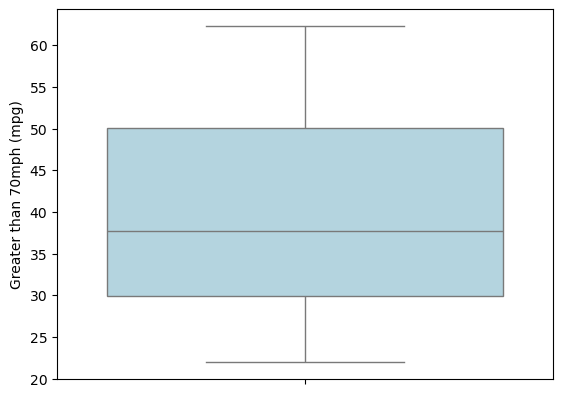

In [23]:
mask_grt_100 = df_grt_70['Instant fuel economy (MPG)'] > 100
mpg_grt_100_grt_70 = mask_grt_100.sum()
mask_lte_100 = df_grt_70['Instant fuel economy (MPG)']  <= 100
mpg_lte_100_grt_70 = mask_lte_100.sum()

mph_grt_70_boost_mean =df_grt_70['Boost (psi)'].mean().round(2) 
mph_grt_70_boost_quantiles=df_grt_70['Boost (psi)'].quantile([0.25,0.50,0.75])
df_grt_70_boost_quantiles = pd.DataFrame(mph_grt_70_boost_quantiles)
df_grt_70_boost_quantiles = df_grt_70_boost_quantiles.reset_index()
df_grt_70_boost_quantiles.columns = ['Percentile', 'Value (psi)']

mpg_grt_70_count=len(df_grt_70)
mpg_grt_70_mpg_mean=df_grt_70['Instant fuel economy (MPG)'].mean().round(2)
mpg_grt_70_100_quantiles=df_grt_70['Instant fuel economy (MPG)'].quantile([0.25,0.50,0.75])
mpg_grt_70_100_per=((mpg_grt_100_grt_70/mpg_grt_70_count)*100).round(2)
df_grt_70_100_quantiles = pd.DataFrame(mpg_grt_70_100_quantiles)
df_grt_70_100_quantiles = df_grt_70_100_quantiles.reset_index()
df_grt_70_100_quantiles.columns = ['Percentile', 'Greater than 70mph (mpg)']

print("Greater Than 70mph")
print(f"Average Boost: {mph_grt_70_boost_mean}")
print(f"Value Counts: {mpg_grt_70_count}")
print(f"Values > 100mpg: {mpg_grt_100_grt_70}")
print(f"Values <= 100mpg: {mpg_lte_100_grt_70}")
print(f"Percent above 100mpg: {mpg_grt_70_100_per}%")
print(f"Mean MPG: {mpg_grt_70_mpg_mean}")
print("mpg Quartiles")
print(df_grt_70_100_quantiles)
print("Boost Quartiles")
print(df_grt_70_boost_quantiles)
sns.boxplot(y=df_grt_70_100_quantiles['Greater than 70mph (mpg)'], color='lightblue')

In [24]:
mpg_count_list=[mpg_40_50_count, mpg_50_60_count, mpg_60_70_count, mpg_grt_70_count]
mpg_lte_100_count_list = [int(mpg_lte_100_40_50), int(mpg_lte_100_50_60), int(mpg_lte_100_60_70), int(mpg_lte_100_grt_70)]
mpg_grt_100_count_list = [int(mpg_grt_100_40_50), int(mpg_grt_100_50_60), int(mpg_grt_100_60_70), int(mpg_grt_100_grt_70)]
mpg_grt_100_per_list=[int(mpg_40_50_100_per),int(mpg_50_60_100_per),int(mpg_60_70_100_per),int(mpg_grt_70_100_per)]

mpg_100_df = pd.DataFrame({
    'total mpg counts': mpg_count_list,
    'total mpg <= 100 counts': mpg_lte_100_count_list,
    'total mpg > 100 counts': mpg_grt_100_count_list,
    '% > 100mpg':mpg_grt_100_per_list
}, index=['40-50mph', '50-60mph', '60-70mph', '>70mph'])

print(f'total mpg counts: {mpg_count_list}')
print(f'total mpg <= 100 counts: {mpg_lte_100_count_list}')
print(f'total mpg > 100 counts: {mpg_grt_100_count_list}')
print(f'% > 100mpg : {mpg_grt_100_per_list}')
mpg_100_df.head()

total mpg counts: [167, 68, 1652, 10]
total mpg <= 100 counts: [147, 44, 1506, 9]
total mpg > 100 counts: [20, 24, 146, 1]
% > 100mpg : [11, 35, 8, 10]


,total mpg counts,total mpg <= 100 counts,total mpg > 100 counts,% > 100mpg
40-50mph,167,147,20,11
50-60mph,68,44,24,35
60-70mph,1652,1506,146,8
>70mph,10,9,1,10


   Percentile  40-50mph (mpg)  50-60mph (mpg)  60-70mph (mpg)  \
0        0.25           18.40          17.125          20.975   
1        0.50           27.60          43.250          32.500   
2        0.75           45.55         122.650          49.625   

   Greater than 70mph (mpg)  
0                    21.975  
1                    37.750  
2                    62.300  


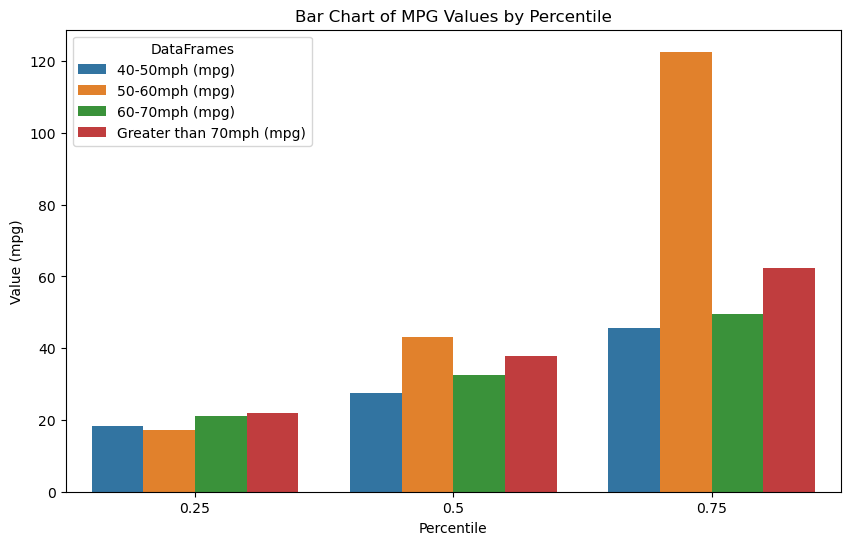

In [25]:
# Merge DataFrames on 'Percentile'
df_quartiles = pd.merge(df_40_50_100_quantiles, df_50_60_100_quantiles, on='Percentile')
df_quartiles = pd.merge(df_quartiles, df_60_70_100_quantiles, on='Percentile')
df_quartiles = pd.merge(df_quartiles, df_grt_70_100_quantiles, on='Percentile')
df_quartiles.head()
print(df_quartiles)

df_long = pd.melt(df_quartiles, id_vars='Percentile', var_name='DataFrame', value_name='Value (mpg)')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x='Percentile', y='Value (mpg)', hue='DataFrame')
plt.title('Bar Chart of MPG Values by Percentile')
plt.xlabel('Percentile')
plt.ylabel('Value (mpg)')
plt.legend(title='DataFrames')
mpg_by_mph_file_path = os.path.join(output_folder_path, 'mpg_by_mph.jpeg')
plt.savefig(mpg_by_mph_file_path, format='jpeg', dpi=300)
plt.show()

In [26]:
df
#convert 
#df_less_10_geo=df_less_10.copy()
#df_less_10_geo.head()
#
#df_10_20_geo = df_10_20.copy()
#df_10_20_geo.head()
#
#df_20_30_geo = df_20_30.copy()
#df_20_30_geo.head()
#
#df_30_40_geo = df_30_40.copy()
#df_30_40_geo.head()
#
#df_40_50_geo = df_40_50.copy()
#df_40_50_geo.head()
#
#df_50_60_geo = df_50_60.copy()
#
#
#df_60_70_geo = df_60_70.copy()

df_55_75_geo = df_55_75.copy()





In [27]:
#map_center = [df_60_70['latitude'].mean(), df_60_70['longitude'].mean()]
#print(map_center)

In [28]:
print("Available colormaps:")
for name in dir(cm):
    if 'colormap' in name.lower():
        print(name)

Available colormaps:
ColorMap
LinearColormap
StepColormap
_LinearColormaps
_StepColormaps


In [29]:
df_map=df_moving.copy()
map_center = [44.980164, -93.185692]
m = folium.Map(location=map_center, zoom_start=11)
coordinates = df_map[['latitude', 'longitude', 'Vehicle speed (MPH)']].values.tolist()
sorted_coordinates = sorted(coordinates, key=lambda x: x[2])
colormap = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],  # Custom color range
    vmin=df_map['Vehicle speed (MPH)'].min(),
    vmax=df_map['Vehicle speed (MPH)'].max(),
    caption='Vehicle Speed (MPH)'   
)

colormap.add_to(m)



for i in range(len(df_map) - 1):
    # Coordinates of the current segment
    start = [df_map.iloc[i]['latitude'], df_map.iloc[i]['longitude']]
    end = [df_map.iloc[i + 1]['latitude'], df_map.iloc[i + 1]['longitude']]
    
    # Value for color mapping (use average or a specific value)
    segment_value = (df_map.iloc[i]['Vehicle speed (MPH)'] + df_map.iloc[i + 1]['Vehicle speed (MPH)']) / 2
    
    # Create and add a PolyLine for each segment
    folium.PolyLine(
        locations=[start, end],
        color=colormap(segment_value),  # Map value to color
        weight=5,
        opacity=1
        ).add_to(m)

# Save the map to an HTML file
map_moving_file_path = os.path.join(output_folder_path, 'map_moving.html')
m.save(map_moving_file_path)


In [30]:
#map_center = [44.980164, -93.185692]
#m = folium.Map(location=map_center, zoom_start=11)
#
#
## Prepare the list of coordinates for the PolyLine
#coordinates = df_55_75_geo[['latitude', 'longitude']].values.tolist()
#
## Add a PolyLine to the map
#folium.PolyLine(
#    locations=coordinates,
#    popup=[str(row['Time (sec)']) for idx, row in df_55_75_geo.iterrows()],
#    weight=5,
#    opacity=1,
#    color='blue'
#).add_to(m)

# Save the map to an HTML file
m.save('mpg_55_75_map.html')

In [31]:
hvexplorer = df.hvplot.explorer()
hvexplorer

/Users/matthewidle/anaconda3/envs/py311/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


BokehModel(combine_events=True, render_bundle={'docs_json': {'87f534c0-fe44-4203-ab69-e48f265b365f': {'version…

In [32]:
df['Engine RPM (RPM)']=df['Engine RPM (RPM)']/100
df['Engine Power (hp)']=df['Engine Power (hp)']/10
df['Ambient air temperature (°F)']=df['Ambient air temperature (°F)']/10
#df['Intake air temperature bank 1  sensor 1 (°F)']=df['Intake air temperature bank 1  sensor 1 (°F)']/10
#df['Relative throttle position (%)']=df['Relative throttle position (%)']/10
#df[' Boost (psi)']=df[' Boost (psi)']/10
#df[' Mass air flow rate (lb/min)']=df[' Mass air flow rate (lb/min)']/10


#df['Boost (psi)']= df['Boost (psi)']/10


In [33]:
start_index = int(round(2227.003))  # or use int(2227.003)
end_index = int(round(2231.996))    # or use int(2255.994)

# Select rows between start_index and end_index (inclusive)
boosted = df.iloc[start_index:end_index + 1]

print(boosted.head())

      Time (sec)  Vehicle speed (MPH)  \
2227    2250.960             6.213712   
2228    2252.006             6.213712   
2229    2252.987             6.213712   
2230    2254.002             1.242742   
2231    2256.007             1.242742   

      Relative accelerator pedal position (%)  Engine RPM (RPM)  Boost (psi)  \
2227                                      0.0              7.77    -9.862566   
2228                                      0.0              7.77    -9.862566   
2229                                      0.0              7.77    -9.862566   
2230                                      0.0              7.37    -8.992340   
2231                                      0.0              7.37    -8.992340   

      Engine Power (hp)  Mass air flow rate (lb/min)  \
2227           0.493566                     0.494184   
2228           0.493566                     0.494184   
2229           0.493566                     0.494184   
2230           0.382784                     0.50

In [34]:
#boosted=df.iloc[2227:2233]
#boosted.head

In [35]:
boosted.hvplot(
    kind='line',
    x='Time (sec)',
    y=['Engine RPM (RPM)','Boost (psi)','Relative throttle position (%)','Vehicle speed (MPH)' ], #'Engine Power (hp)'
    legend='bottom_right',
    widget_location='bottom',
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'a4f84a85-5a96-4abb-b3c1-05529ae4bffe': {'version…

In [36]:
df.hvplot(
    kind='line',
    x='Time (sec)',
    y=['Mass Air/Boost'],
    legend='bottom_right',
    widget_location='bottom',
)

DataError: Supplied data does not contain specified dimensions, the following dimensions were not found: ['Mass Air/Boost']

PandasInterface expects tabular data, for more information on supported datatypes see https://holoviews.org/user_guide/Tabular_Datasets.html

In [ ]:
df.hvplot(
    kind='line',
    x='Time (sec)',
    y=['Mass Air/manPress'],
    legend='bottom_right',
    widget_location='bottom',
)

In [ ]:
df.hvplot(
    kind='line',
    x='Time (sec)',
    y1='Intake air temperature bank 1  sensor 1 (°F)',
    y2='Boost (psi)',
    legend='bottom_right',
    widget_location='bottom',
)

In [ ]:
moving_df.describe()